In [8]:
import numpy as np 

In [49]:
X = np.ones((5,2))
theta = np.array([2, 3])
pred = sigmoid(X.dot(theta)).reshape(-1, 1)
y = np.array([1, 1, 1, 1, 1]).reshape(-1, 1)
m = X.shape[0]

cost = ((-y.T.dot(np.log(pred))) - ((1-y).T.dot(np.log(1-pred)))) / m 
cost 

[[0.99330715]
 [0.99330715]
 [0.99330715]
 [0.99330715]
 [0.99330715]]


array([[0.00671535]])

In [717]:
from sklearn.metrics import f1_score, accuracy_score, classification_report


class LogisticRegressionGD(object):
    def __init__(self, alpha=0.1, n_iter=5000, tol=0.001, random_state=1):
        self.alpha = alpha
        self.n_iter = n_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.cost_ = []
        m = X.shape[0]

        for i in range(self.n_iter):
            pred = self.predict_proba(X)
            errors = y - pred
            cost = sum(-y.T * np.log(pred) - (1 - y).T * np.log(1 - pred))
            if len(self.cost_) > 1:
                if (self.cost_[-1] - cost) <= self.tol:
                    print('Model met tol value of {} in {} iterations with a cost of {:.3f}.'.format(self.tol,
                                                   self.n_iter_,
                                                   self.cost_[-1]))
                    break
            self.cost_.append(cost)
            self.w_ += self.alpha / m * X.T.dot(errors)
            self.n_iter_ = i + 1

        return self

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _net_input(self, X):
        return np.dot(X, self.w_)

    def predict_proba(self, X):
        return self._sigmoid(self._net_input(X))

    def predict(self, X, thresh=0.5):
        proba = self.predict_proba(X)
        predictions = np.where(proba >= thresh, 1, 0)
        return predictions

    def score(self, y_true, y_pred, metric='accuracy', print_report=False):
        if print_report:
            print(classification_report(y_true, y_pred))

        if metric == 'accuracy':
            return accuracy_score(y_true, y_pred)
        elif metric == 'f1':
            return f1_score(y_true, y_pred)
        else:
            raise ValueError(
                "Expected 'f1'; got {}".format(metric))

    def get_best_thresh(self, X, y, thresholds=None):
        if thresholds is None:
            thresholds = np.arange(0.1, 1, 0.05)

        scores = []
        for thresh in thresholds:
            y_pred = self.predict(X, thresh=thresh)
            scores.append(clf.score(y, y_pred))
        
        print(thresholds[np.argmax(scores)])
        return (thresholds, scores)

In [946]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

class MultiLogisticRegressionGD(object):
    def __init__(self, alpha=0.1, n_iter=5000, tol=0.001):
        self.alpha = alpha
        self.n_iter = n_iter
        self.tol = tol

    def fit(self, X, y):
        m = X.shape[0]
        class_labels = np.unique(y)
        
        if len(class_labels) == 2: 
            self.w_ = [np.random.randn(X.shape[1]) * 0.001]
            self.cost_ = [[]]
            self.n_iter_ = [[]]
            for i in range(self.n_iter):
                pred = self.predict_proba(X)
                errors = y - pred
                cost = self._compute_cost(y, pred) #sum(-y.T * np.log(pred) - (1 - y).T * np.log(1 - pred))
                if len(self.cost_[0]) > 1:
                    if (self.cost_[0][-1] - cost) <= self.tol:
                        break
                self.cost_[0].append(cost)
                self.w_[0] += self.alpha / m * X.T.dot(errors)
                self.n_iter_[0] = i + 1
        elif len(class_labels) > 2:
            # Use One-vs-Rest method for multiclass classification
            self.w_ = [np.random.randn(X.shape[1]) * 0.001 for label in class_labels]
            self.cost_ = [[] for label in class_labels]
            self.n_iter_ = [[] for label in class_labels]
            for class_label in class_labels:
                y_temp = np.where(y == class_label, 1, 0)
                # Minimize cost with batch gradient descent
                for i in range(self.n_iter):
                    pred = self.predict_class_proba(X, class_label)
                    errors = y_temp - pred
                    cost = self._compute_cost(y_temp, pred)
                    # Break loop if model converged per tol value
                    if len(self.cost_[class_label]) > 1:
                        if (self.cost_[class_label][-1] - cost) <= self.tol:
                            break
                    self.cost_[class_label].append(cost)
                    self.w_[class_label] += self.alpha / m * X.T.dot(errors)
                    self.n_iter_[class_label] = i + 1

        return self
    
    def _compute_cost(self, y_true, y_pred):
        return sum(-y_true.T * np.log(y_pred) - (1 - y_true).T * np.log(1 - y_pred))

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _net_input(self, X, weight_idx=0):
        return np.dot(X, self.w_[weight_idx])
    
    def predict_class_proba(self, X, weight_idx=0):
        return self._sigmoid(self._net_input(X, weight_idx))

    def predict_proba(self, X):
        output = np.zeros((X.shape[0], len(self.w_)))
        for w in range(len(self.w_)):
            output[:,w] = self.predict_class_proba(X, w)
        if len(self.w_) == 1:
            return output.flatten()
        else:
            return output
            
    def predict(self, X, thresh=0.5):
        # thresh controls the prediction threshold
        # ignored for multiclass classification
        proba = self.predict_proba(X)
        if len(self.w_) == 1:
            return np.where(proba >= thresh, 1, 0)
        else:
            return np.argmax(proba, axis=1)
    
    def score(self, y_true, y_pred, metric='accuracy', print_report=False):
        if print_report:
            print(classification_report(y_true, y_pred))
            
        if metric == 'accuracy':
            return accuracy_score(y_true, y_pred)
        elif metric == 'f1':
            return f1_score(y_true, y_pred)
        else:
            raise ValueError(
                "Expected 'accuracy' or 'f1'; got {}".format(metric))
            
    def get_best_thresh(self, X, thresholds=None):
        if thresholds is None:
            thresholds = np.arange(0.1, 1, 0.05)
        
        scores = []
        for thresh in thresholds:
            y_pred = self.predict(X, thresh=thresh)
            scores.append(clf.score(y, y_pred))
            
        return thresholds[np.argmax(scores)]

In [947]:
# from sklearn.utils import shuffle
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:100]
y = iris.target[:100]
X, y = shuffle(X, y)

In [948]:
import jpy 
X_std = jpy.scale(X)

In [949]:
lr = MultiLogisticRegressionGD(alpha=0.1, tol=0.0001, n_iter=20000)
lr.fit(X_std, y)

In [954]:
y_pred = lr.predict_proba(X_std)
np.round(y_pred,3)

array([0.001, 1.   , 0.008, 1.   , 0.998, 0.   , 0.001, 0.003, 0.005,
       0.   , 0.   , 0.005, 0.   , 0.002, 0.001, 0.002, 1.   , 0.   ,
       0.   , 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.999, 0.   ,
       1.   , 0.   , 1.   , 0.983, 0.   , 1.   , 0.002, 0.001, 0.999,
       0.001, 0.997, 0.999, 0.999, 1.   , 0.001, 0.998, 0.001, 1.   ,
       0.999, 0.989, 0.   , 0.993, 1.   , 0.999, 0.002, 0.001, 0.   ,
       0.999, 0.995, 0.999, 0.001, 0.999, 0.   , 0.001, 0.004, 0.997,
       0.996, 0.998, 0.999, 0.999, 0.001, 0.966, 0.004, 0.996, 1.   ,
       0.001, 0.99 , 0.995, 0.969, 0.033, 0.999, 1.   , 0.001, 1.   ,
       0.002, 1.   , 0.001, 1.   , 0.993, 0.998, 0.997, 0.   , 1.   ,
       0.001, 0.003, 0.998, 0.001, 0.997, 1.   , 1.   , 0.002, 0.999,
       0.001])

In [934]:
lr.n_iter_

[3795, 630, 1033]

In [696]:
def shuffle2(X, y):
    idxs = np.random.permutation(len(y))
    return (X[idxs], y[idxs])

In [748]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data 
y = data.target
X, y = shuffle2(X, y)

In [755]:
X_std = jpy.scale(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y)

In [756]:
lr2 = LogisticRegressionGD(alpha=0.5, n_iter=20000)
lr2.fit(X_train, y_train)

Model met tol value of 0.001 in 2387 iterations with a cost of 14.449.


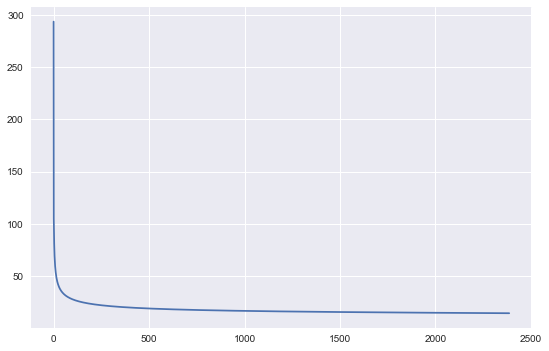

In [757]:
plt.plot(range(lr2.n_iter_), lr2.cost_)

0.3225
0.17


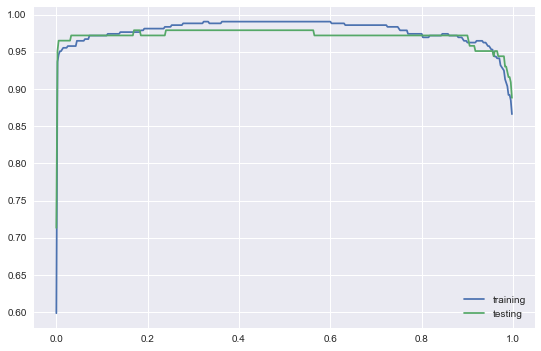

In [758]:
t = np.arange(0, 1, 0.0025)
train_thresh, train_scores = lr2.get_best_thresh(X_train, y_train, thresholds=t)
test_thresh, test_scores = lr2.get_best_thresh(X_test, y_test, thresholds=t)
plt.plot(train_thresh, train_scores, label='training')
plt.plot(test_thresh, test_scores, label='testing')
plt.legend()

In [760]:
pred = lr2.predict(X_train, thresh=0.4)
pred2 = lr2.predict(X_test, thresh=0.4)
print('Training score:', lr2.score(y_train, pred))
print('Testing score:', lr2.score(y_test, pred2))

Training score: 0.9906103286384976
Testing score: 0.9790209790209791


In [691]:
import matplotlib.cm as cm 
from matplotlib.colors import ListedColormap

def plot_decision_regions2(X, y, classifier, test_idx=None, res=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    cmap = cm.get_cmap('rainbow')
    colors = []
    for i in np.arange(0.1, 1.0, 0.1):
        colors.append(cmap(i))
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, res),
                           np.arange(x2_min, x2_max, res))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y == cl, 0], X[y == cl, 1], marker=markers[idx], c=np.array(colors[idx]).reshape(1, -1), alpha=0.6, label=cl, edgecolor='black')
    plt.legend(loc='best')
    plt.show()


In [692]:
from mlxtend.plotting import plot_decision_regions

In [693]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

lr3 = LogisticRegressionGD()
lr3.fit(X_pca, y)

Model met tol value of 0.001 in 738 iterations                     with a cost of 70.900.


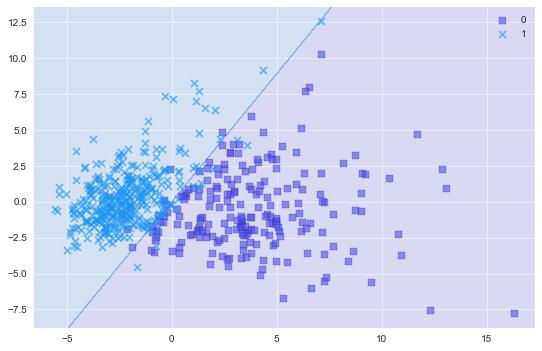

In [694]:
plot_decision_regions2(X_pca, y, lr3)

In [769]:
X_std 

array([[ 1.5514867 , -0.26520386,  1.59533627, ...,  1.67635361,
         1.20078842,  0.45907476],
       [-1.26423005, -1.43106449, -1.14710726, ..., -0.1082036 ,
        -0.08534717,  2.90679142],
       [-0.51897679, -0.78879396, -0.54119942, ..., -1.01190215,
        -0.67745487, -1.15740463],
       ...,
       [-0.35140842, -0.8353353 , -0.32495087, ..., -0.19651786,
        -1.45884291, -0.70244077],
       [-0.79731071,  1.81286709, -0.83241413, ..., -1.42789279,
        -0.08372939, -0.7246071 ],
       [ 1.71905507,  0.05825847,  1.72302589, ...,  1.56367679,
         0.21232446, -0.17709882]])

In [794]:
import jpy

In [795]:
plot_pca_variance(X_std, 15)

NameError: name 'PCA' is not defined